# HOMEWORK 5: TEXT CLASSIFICATION
In this homework, you will create models to classify texts from TRUE call-center. There are two classification tasks:
1. Action Classification: Identify which action the customer would like to take (e.g. enquire, report, cancle)
2. Object Classification: Identify which object the customer is referring to (e.g. payment, truemoney, internet, roaming) 

In this homework, you are asked to do the following tasks:
1. Data Cleaning
2. Preprocessing data for keras
3. Build and evaluate a model for "action" classification
4. Build and evaluate a model for "object" classification
5. Build and evaluate a multi-task model that does both "action" and "object" classifications in one-go 


Note: we have removed phone numbers from the dataset for privacy purposes. 

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# import shutil
# shutil.copy("/content/drive/MyDrive/FRA 501 IntroNLP&DL/Dataset/clean-phone-data.csv", "/content/clean-phone-data.csv")

## Import Libs

In [3]:
%matplotlib inline
import pandas
import sklearn
import numpy as np
from IPython.display import display

import matplotlib.pyplot as plt

## Loading data
First, we load the data from disk into a Dataframe.

A Dataframe is essentially a table, or 2D-array/Matrix with a name for each column.

In [4]:
phone_df = pandas.read_csv('data/hw3_1/clean-phone-data.csv')

Let's preview the data.

In [5]:
# Show the top 5 rows
display(phone_df.head())
# Summarize the data
phone_df.describe()

,Sentence Utterance,Action,Object
0,<PHONE_NUMBER_REMOVED> ผมไปจ่ายเงินที่ Counte...,enquire,payment
1,internet ยังความเร็วอยุ่เท่าไหร ครับ,enquire,package
2,ตะกี้ไปชำระค่าบริการไปแล้ว แต่ยังใช้งานไม่ได้...,report,suspend
3,พี่ค่ะยังใช้ internet ไม่ได้เลยค่ะ เป็นเครื่อ...,enquire,internet
4,ฮาโหล คะ พอดีว่าเมื่อวานเปิดซิมทรูมูฟ แต่มันโ...,report,phone_issues


,Sentence Utterance,Action,Object
count,16175,16175,16175
unique,13389,10,33
top,บริการอื่นๆ,enquire,service
freq,97,10377,2525


## Data cleaning

We call the DataFrame.describe() again.
Notice that there are 33 unique labels/classes for object and 10 unique labels for action that the model will try to predict.
But there are unwanted duplications e.g. Idd,idd,lotalty_card,Lotalty_card

Also note that, there are 13389 unqiue sentence utterances from 16175 utterances. You have to clean that too!

## #TODO 1: 
You will have to remove unwanted label duplications as well as duplications in text inputs. 
Also, you will have to trim out unwanted whitespaces from the text inputs. 
This shouldn't be too hard, as you have already seen it in the demo.



In [6]:
display(phone_df.describe())
display(phone_df.Object.unique())
display(phone_df.Action.unique())

,Sentence Utterance,Action,Object
count,16175,16175,16175
unique,13389,10,33
top,บริการอื่นๆ,enquire,service
freq,97,10377,2525


array(['payment', 'package', 'suspend', 'internet', 'phone_issues',
       'service', 'nonTrueMove', 'balance', 'detail', 'bill', 'credit',
       'promotion', 'mobile_setting', 'iservice', 'roaming', 'truemoney',
       'information', 'lost_stolen', 'balance_minutes', 'idd',
       'TrueMoney', 'garbage', 'Payment', 'IDD', 'ringtone', 'Idd',
       'rate', 'loyalty_card', 'contact', 'officer', 'Balance', 'Service',
       'Loyalty_card'], dtype=object)

array(['enquire', 'report', 'cancel', 'Enquire', 'buy', 'activate',
       'request', 'Report', 'garbage', 'change'], dtype=object)

### **Remove unwanted label duplications**

In [7]:
df_phone = phone_df.copy()

In [8]:
df_phone['Object_clean'] = df_phone['Object'].str.lower().copy()
df_phone['Action_clean'] = df_phone['Action'].str.lower().copy()
display(df_phone.describe())
display(df_phone.Object_clean.unique())
display(df_phone.Action_clean.unique())

,Sentence Utterance,Action,Object,Object_clean,Action_clean
count,16175,16175,16175,16175,16175
unique,13389,10,33,26,8
top,บริการอื่นๆ,enquire,service,service,enquire
freq,97,10377,2525,2528,10484


array(['payment', 'package', 'suspend', 'internet', 'phone_issues',
       'service', 'nontruemove', 'balance', 'detail', 'bill', 'credit',
       'promotion', 'mobile_setting', 'iservice', 'roaming', 'truemoney',
       'information', 'lost_stolen', 'balance_minutes', 'idd', 'garbage',
       'ringtone', 'rate', 'loyalty_card', 'contact', 'officer'],
      dtype=object)

array(['enquire', 'report', 'cancel', 'buy', 'activate', 'request',
       'garbage', 'change'], dtype=object)

In [9]:
df_phone.drop(['Object', 'Action'], axis=1, inplace=True)
df_phone.rename(columns={'Object_clean': 'Object', 'Action_clean': 'Action','Sentence Utterance': 'Sentence'}, inplace=True)

### **Remove Duplications in text inputs**

In [10]:
display(df_phone.describe())

,Sentence,Object,Action
count,16175,16175,16175
unique,13389,26,8
top,บริการอื่นๆ,service,enquire
freq,97,2528,10484


In [11]:
idx = df_phone[df_phone['Sentence'] == 'บริการอื่นๆ'].index
# Show duplicate sentences
display(df_phone.loc[idx])

,Sentence,Object,Action
13676,บริการอื่นๆ,service,enquire
13683,บริการอื่นๆ,service,enquire
13765,บริการอื่นๆ,service,enquire
13853,บริการอื่นๆ,service,enquire
13871,บริการอื่นๆ,service,enquire
...,...,...,...
16010,บริการอื่นๆ,service,enquire
16023,บริการอื่นๆ,service,enquire
16060,บริการอื่นๆ,service,enquire
16115,บริการอื่นๆ,service,enquire


In [12]:
df_phone = df_phone.drop_duplicates("Sentence",keep='first')
display(df_phone.describe())

,Sentence,Object,Action
count,13389,13389,13389
unique,13389,26,8
top,<PHONE_NUMBER_REMOVED> ผมไปจ่ายเงินที่ Counte...,service,enquire
freq,1,2111,8658


### **Remove unwanted whitespaces**

In [13]:
def strip_space(text):
    return text.strip()

df_phone['Sentence'] = df_phone['Sentence'].apply(strip_space)
df_phone.head()

,Sentence,Object,Action
0,<PHONE_NUMBER_REMOVED> ผมไปจ่ายเงินที่ Counter...,payment,enquire
1,internet ยังความเร็วอยุ่เท่าไหร ครับ,package,enquire
2,ตะกี้ไปชำระค่าบริการไปแล้ว แต่ยังใช้งานไม่ได้ ค่ะ,suspend,report
3,พี่ค่ะยังใช้ internet ไม่ได้เลยค่ะ เป็นเครื่อง...,internet,enquire
4,ฮาโหล คะ พอดีว่าเมื่อวานเปิดซิมทรูมูฟ แต่มันโท...,phone_issues,report


### **Remove html tags**

In [14]:
import re

html_tag_pattern = r'<[^>]+>'
def remove_html_tags(text):
    return re.sub(html_tag_pattern, '', text)

df_phone['Sentence_<remove>'] = df_phone['Sentence'].apply(remove_html_tags)
html_tag_idx = df_phone[df_phone['Sentence_<remove>'] != df_phone['Sentence']].index
display(df_phone.loc[html_tag_idx])

,Sentence,Object,Action,Sentence_<remove>
0,<PHONE_NUMBER_REMOVED> ผมไปจ่ายเงินที่ Counter...,payment,enquire,ผมไปจ่ายเงินที่ Counter Services เค้าเช็ต 327...
6,<PHONE_NUMBER_REMOVED> เคยมีช่างมาซ่อมที่บ้าน ...,nontruemove,enquire,เคยมีช่างมาซ่อมที่บ้าน แล้วโทรศัพท์ใช้งานไม่ไ...
7,<PHONE_NUMBER_REMOVED> ค้างค่าบริการเท่าไหร่ครับ,balance,enquire,ค้างค่าบริการเท่าไหร่ครับ
8,<PHONE_NUMBER_REMOVED> อินเตอร์เน็ตไฟ Adsl ไม่...,nontruemove,enquire,อินเตอร์เน็ตไฟ Adsl ไม่มีสัญญาณครับ
9,<PHONE_NUMBER_REMOVED> เค้าบอกจะส่งรหัสเน็ตมาใ...,internet,enquire,เค้าบอกจะส่งรหัสเน็ตมาให้ แต่ยังไม่ได้ส่งมาเล...
...,...,...,...,...
13358,อยากสอบถามว่าเบอร์ '<PHONE_NUMBER_REMOVED> โดน...,payment,enquire,อยากสอบถามว่าเบอร์ ' โดนตัดไปหรือยังค่ะ เนื่อง...
13547,ฮัลโล ทรูน่ะครับผม เบอร์ <PHONE_NUMBER_REMOVED...,nontruemove,enquire,ฮัลโล ทรูน่ะครับผม เบอร์ ครับดูจากประวัติคงทร...
13572,ฮัลโหลครับ ช่วยเช็คสัญญาณอินเตอร์เน็ตเบอร์ <PH...,internet,enquire,ฮัลโหลครับ ช่วยเช็คสัญญาณอินเตอร์เน็ตเบอร์ ให...
13601,ฮัลโหลค่ะพี่ พี่ช่วยเช็คเบอร์ <PHONE_NUMBER_RE...,balance,enquire,ฮัลโหลค่ะพี่ พี่ช่วยเช็คเบอร์ ว่าเน็ตมันหมดมั...


In [15]:
df_phone.drop(['Sentence'], axis=1, inplace=True)
df_phone.rename(columns={'Sentence_<remove>': 'Sentence'}, inplace=True)
display(df_phone.head())

,Object,Action,Sentence
0,payment,enquire,ผมไปจ่ายเงินที่ Counter Services เค้าเช็ต 327...
1,package,enquire,internet ยังความเร็วอยุ่เท่าไหร ครับ
2,suspend,report,ตะกี้ไปชำระค่าบริการไปแล้ว แต่ยังใช้งานไม่ได้ ค่ะ
3,internet,enquire,พี่ค่ะยังใช้ internet ไม่ได้เลยค่ะ เป็นเครื่อง...
4,phone_issues,report,ฮาโหล คะ พอดีว่าเมื่อวานเปิดซิมทรูมูฟ แต่มันโท...


### **English lowercase**

In [16]:
eng_char = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z','A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']
def check_eng_char(text):
    for char in text:
        if char in eng_char:
            return True
    return False

df_phone['Eng'] = df_phone['Sentence'].apply(check_eng_char)
eng_idx = df_phone[df_phone['Eng'] == True].index
display(df_phone.loc[eng_idx])

,Object,Action,Sentence,Eng
0,payment,enquire,ผมไปจ่ายเงินที่ Counter Services เค้าเช็ต 327...,True
1,package,enquire,internet ยังความเร็วอยุ่เท่าไหร ครับ,True
3,internet,enquire,พี่ค่ะยังใช้ internet ไม่ได้เลยค่ะ เป็นเครื่อง...,True
8,nontruemove,enquire,อินเตอร์เน็ตไฟ Adsl ไม่มีสัญญาณครับ,True
21,internet,enquire,มีการเปิดใช้งาน GPRS หรือป่าว,True
...,...,...,...,...
13618,mobile_setting,enquire,ฮาโหลครับ คือผม ผมเปลี่ยนจากทรูมูฟเป็นทรูมูฟเอ...,True
13624,rate,enquire,ฮาโหลครับ ผมสอบถามนิดนึงครับ คือผมจะตั้งให้อีเ...,True
13625,package,buy,ฮาโหลครับ สมัคร Buffet ทรูมูฟ กดอะไรครับ,True
13629,phone_issues,report,ฮาโหลค่ะ เพิ่งซื้อ Goal live มาแล้วโทรออกไม่ได...,True


In [17]:
def lower_case(text):
    return text.lower()

df_phone['Sentence'] = df_phone['Sentence'].apply(lower_case)
display(df_phone.loc[eng_idx])

,Object,Action,Sentence,Eng
0,payment,enquire,ผมไปจ่ายเงินที่ counter services เค้าเช็ต 327...,True
1,package,enquire,internet ยังความเร็วอยุ่เท่าไหร ครับ,True
3,internet,enquire,พี่ค่ะยังใช้ internet ไม่ได้เลยค่ะ เป็นเครื่อง...,True
8,nontruemove,enquire,อินเตอร์เน็ตไฟ adsl ไม่มีสัญญาณครับ,True
21,internet,enquire,มีการเปิดใช้งาน gprs หรือป่าว,True
...,...,...,...,...
13618,mobile_setting,enquire,ฮาโหลครับ คือผม ผมเปลี่ยนจากทรูมูฟเป็นทรูมูฟเอ...,True
13624,rate,enquire,ฮาโหลครับ ผมสอบถามนิดนึงครับ คือผมจะตั้งให้อีเ...,True
13625,package,buy,ฮาโหลครับ สมัคร buffet ทรูมูฟ กดอะไรครับ,True
13629,phone_issues,report,ฮาโหลค่ะ เพิ่งซื้อ goal live มาแล้วโทรออกไม่ได...,True


In [18]:
df_phone.drop(['Eng'], axis=1, inplace=True)
display(df_phone.head())

,Object,Action,Sentence
0,payment,enquire,ผมไปจ่ายเงินที่ counter services เค้าเช็ต 327...
1,package,enquire,internet ยังความเร็วอยุ่เท่าไหร ครับ
2,suspend,report,ตะกี้ไปชำระค่าบริการไปแล้ว แต่ยังใช้งานไม่ได้ ค่ะ
3,internet,enquire,พี่ค่ะยังใช้ internet ไม่ได้เลยค่ะ เป็นเครื่อง...
4,phone_issues,report,ฮาโหล คะ พอดีว่าเมื่อวานเปิดซิมทรูมูฟ แต่มันโท...


### **Label Mapping**

In [19]:
def get_label_map(df, col_name):
    label_map = {}
    for i, label in enumerate(df[col_name].unique()):
        label_map[label] = i
    reversed_label_map = {v: k for k, v in label_map.items()}
    return label_map, reversed_label_map

object_label_map, object_reversed_label_map = get_label_map(df_phone, 'Object')
display(object_label_map)

{'payment': 0,
 'package': 1,
 'suspend': 2,
 'internet': 3,
 'phone_issues': 4,
 'service': 5,
 'nontruemove': 6,
 'balance': 7,
 'detail': 8,
 'bill': 9,
 'credit': 10,
 'promotion': 11,
 'mobile_setting': 12,
 'iservice': 13,
 'roaming': 14,
 'truemoney': 15,
 'information': 16,
 'lost_stolen': 17,
 'balance_minutes': 18,
 'idd': 19,
 'garbage': 20,
 'ringtone': 21,
 'rate': 22,
 'loyalty_card': 23,
 'contact': 24,
 'officer': 25}

In [20]:
action_label_map, action_reversed_label_map = get_label_map(df_phone, 'Action')
display(action_label_map)

{'enquire': 0,
 'report': 1,
 'cancel': 2,
 'buy': 3,
 'activate': 4,
 'request': 5,
 'garbage': 6,
 'change': 7}

In [21]:
df_phone['Object'] = df_phone['Object'].map(object_label_map)
df_phone['Action'] = df_phone['Action'].map(action_label_map)
display(df_phone.head())

,Object,Action,Sentence
0,0,0,ผมไปจ่ายเงินที่ counter services เค้าเช็ต 327...
1,1,0,internet ยังความเร็วอยุ่เท่าไหร ครับ
2,2,1,ตะกี้ไปชำระค่าบริการไปแล้ว แต่ยังใช้งานไม่ได้ ค่ะ
3,3,0,พี่ค่ะยังใช้ internet ไม่ได้เลยค่ะ เป็นเครื่อง...
4,4,1,ฮาโหล คะ พอดีว่าเมื่อวานเปิดซิมทรูมูฟ แต่มันโท...


In [22]:
display(df_phone.Object.unique())
display(df_phone.Action.unique())

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25], dtype=int64)

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64)

### **Copy data**

In [23]:
df_action = df_phone.copy()[['Sentence', 'Action']]
display(df_action.head())

,Sentence,Action
0,ผมไปจ่ายเงินที่ counter services เค้าเช็ต 327...,0
1,internet ยังความเร็วอยุ่เท่าไหร ครับ,0
2,ตะกี้ไปชำระค่าบริการไปแล้ว แต่ยังใช้งานไม่ได้ ค่ะ,1
3,พี่ค่ะยังใช้ internet ไม่ได้เลยค่ะ เป็นเครื่อง...,0
4,ฮาโหล คะ พอดีว่าเมื่อวานเปิดซิมทรูมูฟ แต่มันโท...,1


In [24]:
df_object = df_phone.copy()[['Sentence', 'Object']]
display(df_object.head())

,Sentence,Object
0,ผมไปจ่ายเงินที่ counter services เค้าเช็ต 327...,0
1,internet ยังความเร็วอยุ่เท่าไหร ครับ,1
2,ตะกี้ไปชำระค่าบริการไปแล้ว แต่ยังใช้งานไม่ได้ ค่ะ,2
3,พี่ค่ะยังใช้ internet ไม่ได้เลยค่ะ เป็นเครื่อง...,3
4,ฮาโหล คะ พอดีว่าเมื่อวานเปิดซิมทรูมูฟ แต่มันโท...,4


In [25]:
df_all = df_phone.copy()
display(df_all.head())

,Object,Action,Sentence
0,0,0,ผมไปจ่ายเงินที่ counter services เค้าเช็ต 327...
1,1,0,internet ยังความเร็วอยุ่เท่าไหร ครับ
2,2,1,ตะกี้ไปชำระค่าบริการไปแล้ว แต่ยังใช้งานไม่ได้ ค่ะ
3,3,0,พี่ค่ะยังใช้ internet ไม่ได้เลยค่ะ เป็นเครื่อง...
4,4,1,ฮาโหล คะ พอดีว่าเมื่อวานเปิดซิมทรูมูฟ แต่มันโท...


## #TODO 2: Preprocessing data for Keras
You will be using Tensorflow 2 keras in this assignment. Please show us how you prepare your data for keras.
Don't forget to split data into train and test sets (+ validation set if you want)

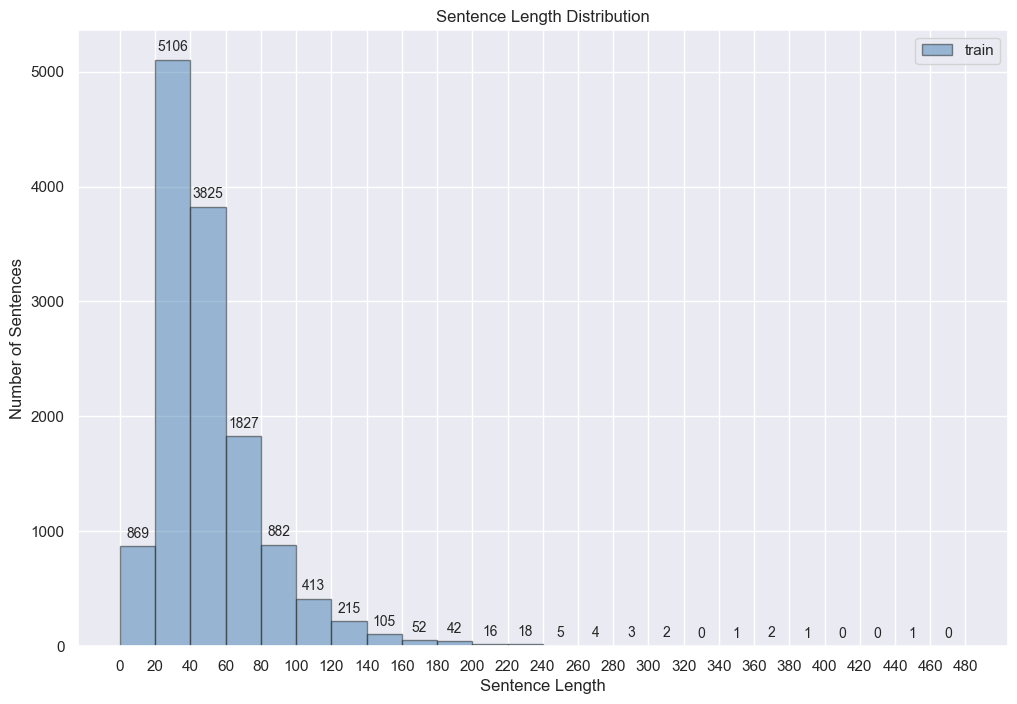

In [26]:
# Plot sentence length distribution
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
sns.set(font_scale=1.0)
plt.rcParams['figure.figsize'] = (12, 8)
 
def plot_sentence_length_distribution(df, col_name):
    bin_size = 20
    bins = np.arange(0, 500, bin_size)
    plt.hist(df[col_name].str.len(), bins=bins, alpha=0.5, color='steelblue', edgecolor='k', label='train')
    xticks = np.arange(0, 500, bin_size)
    plt.xticks(xticks, xticks)
    yticks = np.arange(0, 6000, 1000)
    plt.yticks(yticks, yticks)
    plt.title('Sentence Length Distribution')
    plt.legend(loc='upper right')
    plt.xlabel('Sentence Length')
    plt.ylabel('Number of Sentences')
    for a, b in zip(bins, np.histogram(df[col_name].str.len(), bins=bins)[0]):
        plt.text(a + 10, b + 50, '%d' % b, ha='center', va='bottom', fontsize=10)
    plt.show()

plot_sentence_length_distribution(df_all, 'Sentence')

In [27]:
print('Max sentence length:', df_all['Sentence'].apply(len).max())

Max sentence length: 445


In [28]:
# Remove sentence with length > 200
df_all = df_all[df_all['Sentence'].apply(len) <= 200]
print(f'Removed {round((1 - len(df_all) / len(df_phone)) * 100, 2)}% of sentences')
print('Remaining sentences:', len(df_all))
print('Max sentence length:', df_all['Sentence'].apply(len).max())

Removed 0.39% of sentences
Remaining sentences: 13337
Max sentence length: 200


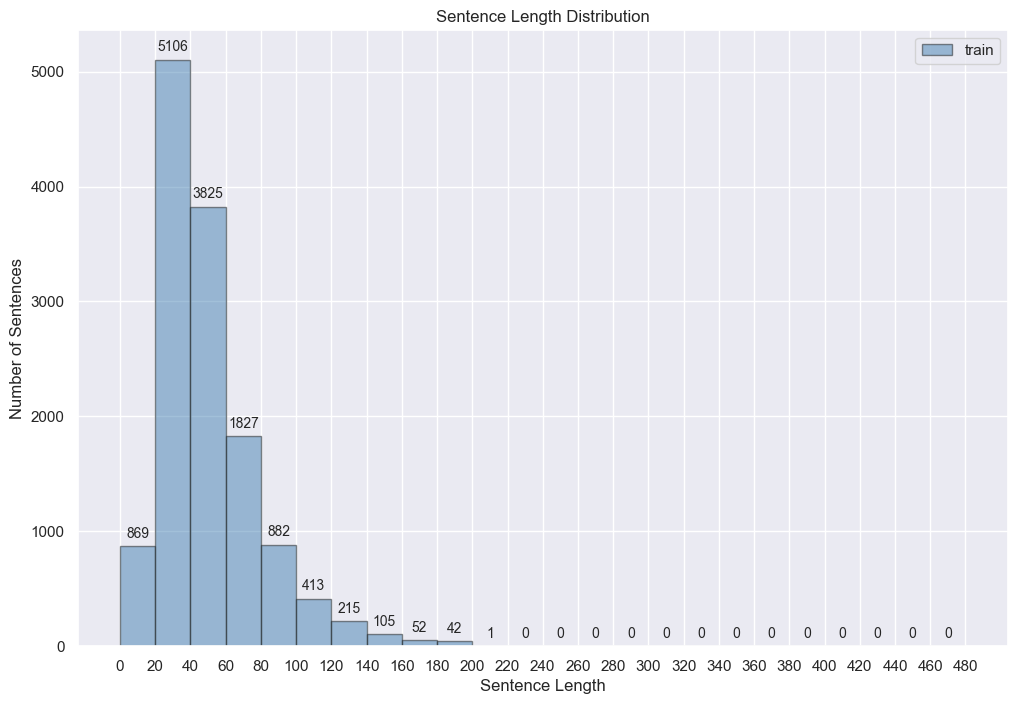

In [29]:
plot_sentence_length_distribution(df_all, 'Sentence')

In [30]:
print('Max sentence length:', df_all['Sentence'].apply(len).max())
max_len_sentence_idx = df_all['Sentence'].apply(len).idxmax()
print(f'is this sentence: \n{df_all["Sentence"][max_len_sentence_idx]}')

Max sentence length: 200
is this sentence: 
จะซื้อ นิวส์ไอแพด พอดีเห็นโปรฯ หน้าเว็บ แจ้งว่าหากใช้บัตร ทรูการ์ดจะได้ส่วนลดค่าเครื่อง 2000 บาท ตรงนี้หมดเขตเมื่อไรครับ ส่วนลดค่าเครื่อง 2000 บาทใช้ได้ถึงเมื่อไรครับ แล้วใช้ได้กับเครื่องทุกรุ่นเลยไหม


In [31]:
df_all

,Object,Action,Sentence
0,0,0,ผมไปจ่ายเงินที่ counter services เค้าเช็ต 327...
1,1,0,internet ยังความเร็วอยุ่เท่าไหร ครับ
2,2,1,ตะกี้ไปชำระค่าบริการไปแล้ว แต่ยังใช้งานไม่ได้ ค่ะ
3,3,0,พี่ค่ะยังใช้ internet ไม่ได้เลยค่ะ เป็นเครื่อง...
4,4,1,ฮาโหล คะ พอดีว่าเมื่อวานเปิดซิมทรูมูฟ แต่มันโท...
...,...,...,...
16167,9,0,ต้องการทราบวันตัดรอบบิลค่ะ
16170,3,0,เชื่อมต่ออินเตอร์เน็ตไม่ได้ค่ะ
16172,7,0,ยอดเงินเหลือเท่าไหร่ค่ะ
16173,7,0,ยอดเงินในระบบ


In [32]:
xtsa = df_all[df_all['Object'] == 24]['Sentence'].values
print(xtsa)

['ได้รับข้อความแจ้งเตือนการใช้งาน'
 'จะขอสอบถามเรืองได้รับ เอสเอ็มเอสเรื่องแจ้งเตื่อนการใช้งานเกินวงเงินค่ะ'
 'พอดีพี่จะสอบถาม พี่เห็นคัสโตเมอร์แคร์โทรหาพี่หลายครั้งแล้ว มีอะไรหรือเปล่าค่า'
 'มีคน โทร หาจึง โทร กลับมาต้องการทราบว่าติดต่อเรื่องอะไร']


### **Plot the distribution of labels**

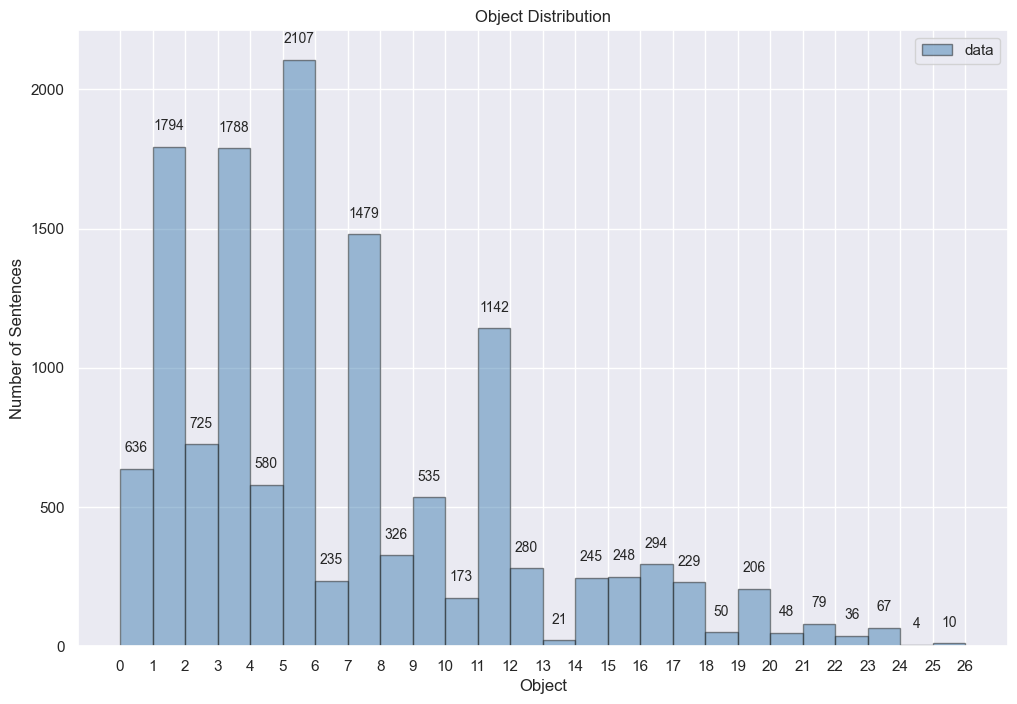

In [33]:
# plot object distribution
sns.set_style('darkgrid')
sns.set(font_scale=1.0)
plt.rcParams['figure.figsize'] = (12, 8)

def plot_label_distribution(df, col_name, title):
    bin_size = 1
    bins = np.arange(0, df[col_name].nunique() + 1, bin_size)
    plt.hist(df[col_name], bins=bins, alpha=0.5, color='steelblue', edgecolor='k', label='data')
    xticks = np.arange(0, df[col_name].nunique() + 1, bin_size)
    plt.xticks(xticks, xticks)
    yticks = np.arange(0, df[col_name].value_counts().max() + 100, 500)
    plt.yticks(yticks, yticks)
    plt.title(title)
    plt.legend(loc='upper right')
    plt.xlabel('Object')
    plt.ylabel('Number of Sentences')
    for a, b in zip(bins, np.histogram(df[col_name], bins=bins)[0]):
        plt.text(a + 0.5, b + 50, '%d' % b, ha='center', va='bottom', fontsize=10)
    plt.show()

plot_label_distribution(df_all, 'Object', 'Object Distribution')

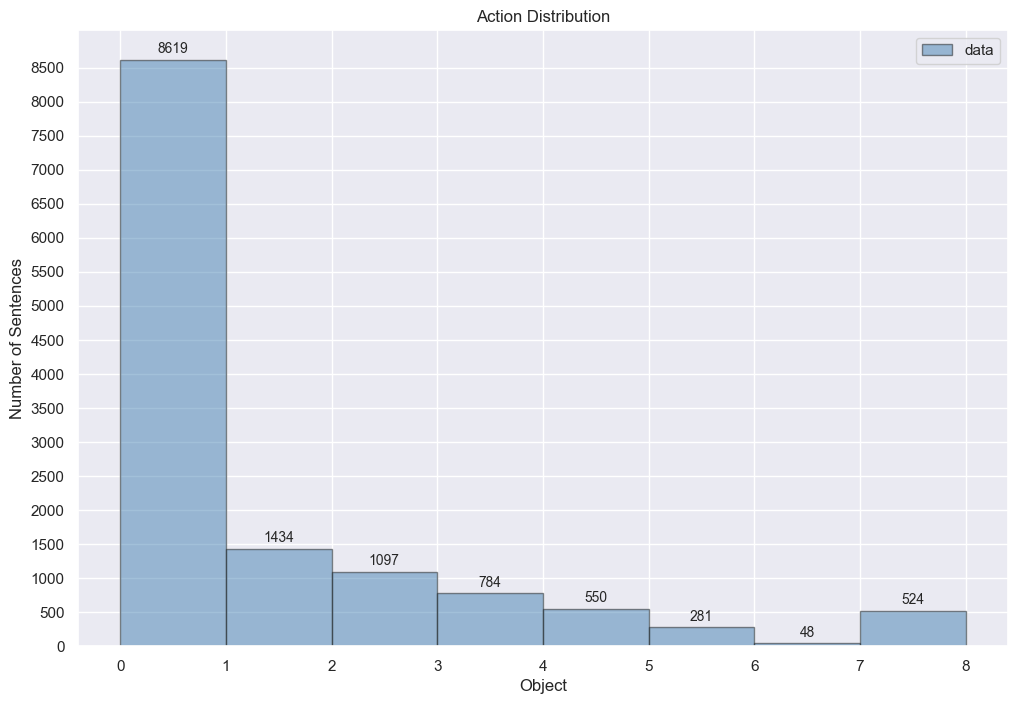

In [34]:
plot_label_distribution(df_all, 'Action', 'Action Distribution')

### **Tokenize**

In [35]:
# Text tokenization
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

def get_tokenizer(df, col_name, num_words):
    tokenizer = Tokenizer(num_words=num_words, oov_token='<UNK>')
    tokenizer.fit_on_texts(df[col_name])
    return tokenizer

def get_sequence(tokenizer, df, col_name, max_len):
    sequences = tokenizer.texts_to_sequences(df[col_name])
    padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post', dtype='int32', value=0.)
    return padded_sequences

def get_label(df, col_name):
    return np.array(df[col_name])

def get_vocab_size(tokenizer):
    return len(tokenizer.word_index) + 1

def get_max_len(df, col_name):
    return max(df[col_name].apply(len))

Tokenizer = get_tokenizer(df_all, 'Sentence', 10000)
vocab_size = get_vocab_size(Tokenizer)
max_len = get_max_len(df_all, 'Sentence')
print('Vocab size:', vocab_size)
print('Max length:', max_len)
text_sequences = get_sequence(Tokenizer, df_all, 'Sentence', max_len)

Vocab size: 23764
Max length: 200


In [36]:
print('Text sequences shape:', text_sequences.shape)
print('Text sequences:')
print(text_sequences)

Text sequences shape: (13337, 200)
Text sequences:
[[2268 2269  726 ...    0    0    0]
 [   6 2274    3 ...    0    0    0]
 [2275  727    2 ...    0    0    0]
 ...
 [   1    0    0 ...    0    0    0]
 [   1    0    0 ...    0    0    0]
 [   1    0    0 ...    0    0    0]]


In [37]:
word_index = Tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
data_maped = {v: k for k, v in word_index.items()}
data_maped[0] = '<PAD>'
def map_encoded_to_word(encoded):
    return [data_maped[word] for word in encoded]
print(f'Encoded: {text_sequences[0][:14]}')
print(f'Decoded: {map_encoded_to_word(text_sequences[0][:14])}')

Found 23763 unique tokens.
Encoded: [2268 2269  726 2270 2271  248    8 2272 2273  309    8    0    0    0]
Decoded: ['ผมไปจ่ายเงินที่', 'counter', 'services', 'เค้าเช็ต', '3276', '25', 'บาท', 'เมื่อวานที่ผมเช็คที่ศูนย์บอกมียอด', '3057', '79', 'บาท', '<PAD>', '<PAD>', '<PAD>']


### **Vectorize**

In [38]:
# Text vectorization
# import tensorflow as tf
# import string
# from keras.layers import TextVectorization

In [39]:
# # Set the parameters for the vectorization layer
# batch_size = 128

In [40]:
# # Set the parameters for the vectorization layer
# max_features = 10000
# sequence_length = 100
# batch_size = 128

# def custom_standardization(input_data):
#   lowercase = tf.strings.lower(input_data)
#   stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
#   return tf.strings.regex_replace(stripped_html,
#                                   '[%s]' % re.escape(string.punctuation),
#                                   '')

# # Create the text vectorization layer
# vectorize_layer = TextVectorization(
#     standardize=custom_standardization,
#     max_tokens=max_features,
#     output_mode='int',
#     output_sequence_length=sequence_length)

### **Split data**

In [41]:
random_state = 1
np.random.seed(random_state)

In [42]:
print('Text sequences shape:', text_sequences.shape)
object_labels = get_label(df_all, 'Object')
action_labels = get_label(df_all, 'Action')
print('Object labels shape:', object_labels.shape)
print('Action labels shape:', action_labels.shape)

Text sequences shape: (13337, 200)
Object labels shape: (13337,)
Action labels shape: (13337,)


In [43]:
text_data_with_label = [{'text': text_sequences[i],
                         'object_label': object_labels[i],
                          'action_label': action_labels[i]} 
                          for i in range(len(text_sequences))]

In [44]:
text_data_with_label[4]

{'text': array([ 228,    7, 2277, 2278, 2279,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0

In [45]:
# Split data into train, validation, and test sets
from sklearn.model_selection import train_test_split

def split_data(data, lable, test_size=0.2, val_size=0.2, shuffle=False):
    train_data, test_data, train_labels, test_labels = train_test_split(data, lable, test_size=test_size, random_state=random_state, shuffle=shuffle)
    train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=val_size, random_state=random_state, shuffle=shuffle)
    return [train_data, train_labels], [val_data, val_labels], [test_data, test_labels]

def split_data_with_label(data, test_size=0.2, val_size=0.2):
    train_data, test_data = train_test_split(data, test_size=test_size, random_state=random_state, shuffle=True)
    train_data, val_data = train_test_split(train_data, test_size=val_size, random_state=random_state, shuffle=True)
    return train_data, val_data, test_data

In [46]:
action_train, action_val, action_test = split_data(text_sequences, action_labels, shuffle=True)
object_train, object_val, object_test = split_data(text_sequences, object_labels, shuffle=True)

In [47]:
print('Action train data shape:', action_train[0].shape)
print('Action train labels shape:', action_train[1].shape)
print(f'Example: \n{action_train[0][0]}')
print(f'Decoded: \n{map_encoded_to_word(action_train[0][0])[0:10]}')
print(f'Label: \n{action_train[1][0]}')

Action train data shape: (8535, 200)
Action train labels shape: (8535,)
Example: 
[  1 476 159  21   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]
Decoded: 
['<UNK>', 'ใช้กับ', 'ไอแพด', 'ไม่ได้', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
La

In [48]:
print('Label distribution:')
print('Train:', np.unique(action_train[1], return_counts=True))
print('Validation:', np.unique(action_val[1], return_counts=True))
print('Test:', np.unique(action_test[1], return_counts=True))

Label distribution:
Train: (array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64), array([5583,  941,  671,  482,  334,  185,   26,  313], dtype=int64))
Validation: (array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64), array([1362,  202,  175,  150,   86,   48,   12,   99], dtype=int64))
Test: (array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64), array([1674,  291,  251,  152,  130,   48,   10,  112], dtype=int64))


## **Train Function**

In [49]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from time import time
from datetime import timedelta
import keras
from keras.models import load_model
import os

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

def build_model(model, address = None,X = None, Y = None, x_val = None, y_val = None, batch_size = 32, epochs = 10):
    """
    Fit the model if the model checkpoint does not exist or else
    load it from that address.
    """
    if (not os.path.exists(address)):
        print(f'Model checkpoint does not exist. Building model and saving it to {address}...')

        losshistory = LossHistory()

        stop = EarlyStopping(monitor = 'val_loss', min_delta = 0, 
                             patience = 5, verbose = 1, mode = 'auto')
        save = ModelCheckpoint(address, monitor = 'val_loss', 
                               verbose = 0, save_best_only = True)
        callbacks = [stop, save,losshistory]

        start = time()
        history = model.fit(X, Y, batch_size = batch_size, 
                            epochs = epochs, verbose = 1,
                            validation_data = (x_val, y_val),
                            callbacks = callbacks)
        elapse = time() - start
        print('elapsed time: ', elapse)
        model_info = {'history': history, 'elapse': elapse, 'model': model}
        model.save(address)
    else:
        print(f'Model checkpoint exists. Loading model from {address}...')
        model = load_model(address)
        model_info = {'model': model}

    return model_info

def retrain_model(model, address = None,X = None, Y = None, x_val = None, y_val = None, batch_size = 32, epochs = 10):
    """
    Fit the model if the model checkpoint does not exist or else
    load it from that address.
    """
    if address is not None or not os.path.isfile(address):
        model = load_model(address)
        stop = EarlyStopping(monitor = 'val_loss', min_delta = 0, 
                             patience = 5, verbose = 1, mode = 'auto')
        save = ModelCheckpoint(address, monitor = 'val_loss', 
                               verbose = 0, save_best_only = True)
        callbacks = [stop, save]

        start = time()
        history = model.fit(X, Y, batch_size = batch_size, 
                            epochs = epochs, verbose = 1,
                            validation_data = (x_val, y_val),
                            callbacks = callbacks)
        elapse = time() - start
        print('elapsed time: ', elapse)
        model_info = {'history': history, 'elapse': elapse, 'model': model}
        model.save(address)
    return model_info

In [50]:
# Number of classes
num_object_classes = len(df_all['Object'].unique())
num_action_classes = len(df_all['Action'].unique())
print('Number of object classes:', num_object_classes)
print('Number of action classes:', num_action_classes)

Number of object classes: 26
Number of action classes: 8


## #TODO 3: Build and evaluate a model for "action" classification


In [51]:
#TODO 3: Build and evaluate a model for "action" classification
from keras.models import Sequential, Model
from keras.layers import Embedding, Reshape, Activation, Input, Dense,GRU,Reshape,TimeDistributed,Bidirectional,Dropout,Masking,LSTM, GlobalAveragePooling1D, Conv1D, MaxPooling1D, Flatten,GlobalMaxPooling1D
from keras.optimizers import Adam
from keras import backend as K                                                          
from keras.callbacks import ModelCheckpoint, TensorBoard

In [52]:
def Text_Classification_Model(vocab_size, max_len, num_classes, embeddim = 32,model_name= 'Text_Classification_Model'):
    input = Input(shape=(max_len,))
    embedding = Embedding(vocab_size, embeddim, input_length=max_len)(input)
    x = Dropout(0.2)(embedding)
    x = Conv1D(32, 5, activation='relu')(x)
    x = MaxPooling1D(5)(x)
    x = Conv1D(32, 5, activation='relu')(x)
    x = GlobalMaxPooling1D()(x)
    output = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=input, outputs=output, name=model_name)
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [53]:
action_model = Text_Classification_Model(vocab_size, max_len, num_action_classes,embeddim= 32)
action_model_info = build_model(action_model,
                            address = 'action_model',
                            X = action_train[0],
                            Y = action_train[1],
                            x_val = action_val[0],
                            y_val = action_val[1],
                            batch_size = 32,
                            epochs = 10)
action_model = action_model_info['model']
action_model.summary()

Model checkpoint does not exist. Building model and saving it to action_model...
Epoch 1/10
267/267 [==============================] - ETA: 0s - loss: 1.2859 - accuracy: 0.6507

INFO:tensorflow:Assets written to: action_model\assets


INFO:tensorflow:Assets written to: action_model\assets


267/267 [==============================] - 9s 30ms/step - loss: 1.2859 - accuracy: 0.6507 - val_loss: 1.3208 - val_accuracy: 0.6382
Epoch 2/10
267/267 [==============================] - ETA: 0s - loss: 1.2360 - accuracy: 0.6541

INFO:tensorflow:Assets written to: action_model\assets


INFO:tensorflow:Assets written to: action_model\assets


267/267 [==============================] - 7s 26ms/step - loss: 1.2360 - accuracy: 0.6541 - val_loss: 1.2929 - val_accuracy: 0.6382
Epoch 3/10
267/267 [==============================] - 5s 20ms/step - loss: 1.2375 - accuracy: 0.6541 - val_loss: 1.3006 - val_accuracy: 0.6382
Epoch 4/10
266/267 [============================>.] - ETA: 0s - loss: 1.2229 - accuracy: 0.6535

INFO:tensorflow:Assets written to: action_model\assets


INFO:tensorflow:Assets written to: action_model\assets


267/267 [==============================] - 7s 24ms/step - loss: 1.2216 - accuracy: 0.6541 - val_loss: 1.2691 - val_accuracy: 0.6382
Epoch 5/10
267/267 [==============================] - ETA: 0s - loss: 1.1566 - accuracy: 0.6541

INFO:tensorflow:Assets written to: action_model\assets


INFO:tensorflow:Assets written to: action_model\assets


267/267 [==============================] - 7s 25ms/step - loss: 1.1566 - accuracy: 0.6541 - val_loss: 1.2466 - val_accuracy: 0.6382
Epoch 6/10
267/267 [==============================] - 6s 24ms/step - loss: 1.0436 - accuracy: 0.6612 - val_loss: 1.2566 - val_accuracy: 0.6439
Epoch 7/10
267/267 [==============================] - 6s 23ms/step - loss: 0.9446 - accuracy: 0.7158 - val_loss: 1.2757 - val_accuracy: 0.6439
Epoch 8/10
267/267 [==============================] - 7s 25ms/step - loss: 0.8750 - accuracy: 0.7347 - val_loss: 1.2909 - val_accuracy: 0.6387
Epoch 9/10
267/267 [==============================] - 6s 23ms/step - loss: 0.8170 - accuracy: 0.7448 - val_loss: 1.2970 - val_accuracy: 0.6326
Epoch 10/10
267/267 [==============================] - 6s 22ms/step - loss: 0.7716 - accuracy: 0.7607 - val_loss: 1.3267 - val_accuracy: 0.6326
Epoch 10: early stopping
elapsed time:  66.02449226379395


INFO:tensorflow:Assets written to: action_model\assets


INFO:tensorflow:Assets written to: action_model\assets


Model: "Text_Classification_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 32)           760448    
                                                                 
 dropout (Dropout)           (None, 200, 32)           0         
                                                                 
 conv1d (Conv1D)             (None, 196, 32)           5152      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 39, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 35, 32)            5152      
                                         

### **Predict**

In [54]:
y_pred = action_model.predict(action_test[0])

84/84 [==============================] - 1s 4ms/step


In [55]:
y_unique = np.unique(action_test[1])
y_true = action_test[1]
y_pred = np.argmax(y_pred, axis=1)
print(f'True unique labels: {y_unique}')
print(f'Predicted unique labels: {np.unique(y_pred)}')
print(f'Accuracy: {np.mean(y_pred == action_test[1]) * 100:.2f}%')

True unique labels: [0 1 2 3 4 5 6 7]
Predicted unique labels: [0 1 2 3]
Accuracy: 61.51%


### **Evaluate**

In [56]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(16, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [57]:
# Classifications report
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay ,multilabel_confusion_matrix

In [58]:
print(f'Action label: {action_reversed_label_map}')
action_class = [x for x in action_label_map.keys()]
print(f'Action class: {action_class}')

Action label: {0: 'enquire', 1: 'report', 2: 'cancel', 3: 'buy', 4: 'activate', 5: 'request', 6: 'garbage', 7: 'change'}
Action class: ['enquire', 'report', 'cancel', 'buy', 'activate', 'request', 'garbage', 'change']


In [59]:
print(classification_report(y_true, y_pred, target_names=action_class,zero_division=0))

              precision    recall  f1-score   support

     enquire       0.66      0.90      0.76      1674
      report       0.28      0.12      0.17       291
      cancel       0.41      0.28      0.34       251
         buy       0.34      0.21      0.26       152
    activate       0.00      0.00      0.00       130
     request       0.00      0.00      0.00        48
     garbage       0.00      0.00      0.00        10
      change       0.00      0.00      0.00       112

    accuracy                           0.62      2668
   macro avg       0.21      0.19      0.19      2668
weighted avg       0.50      0.62      0.54      2668



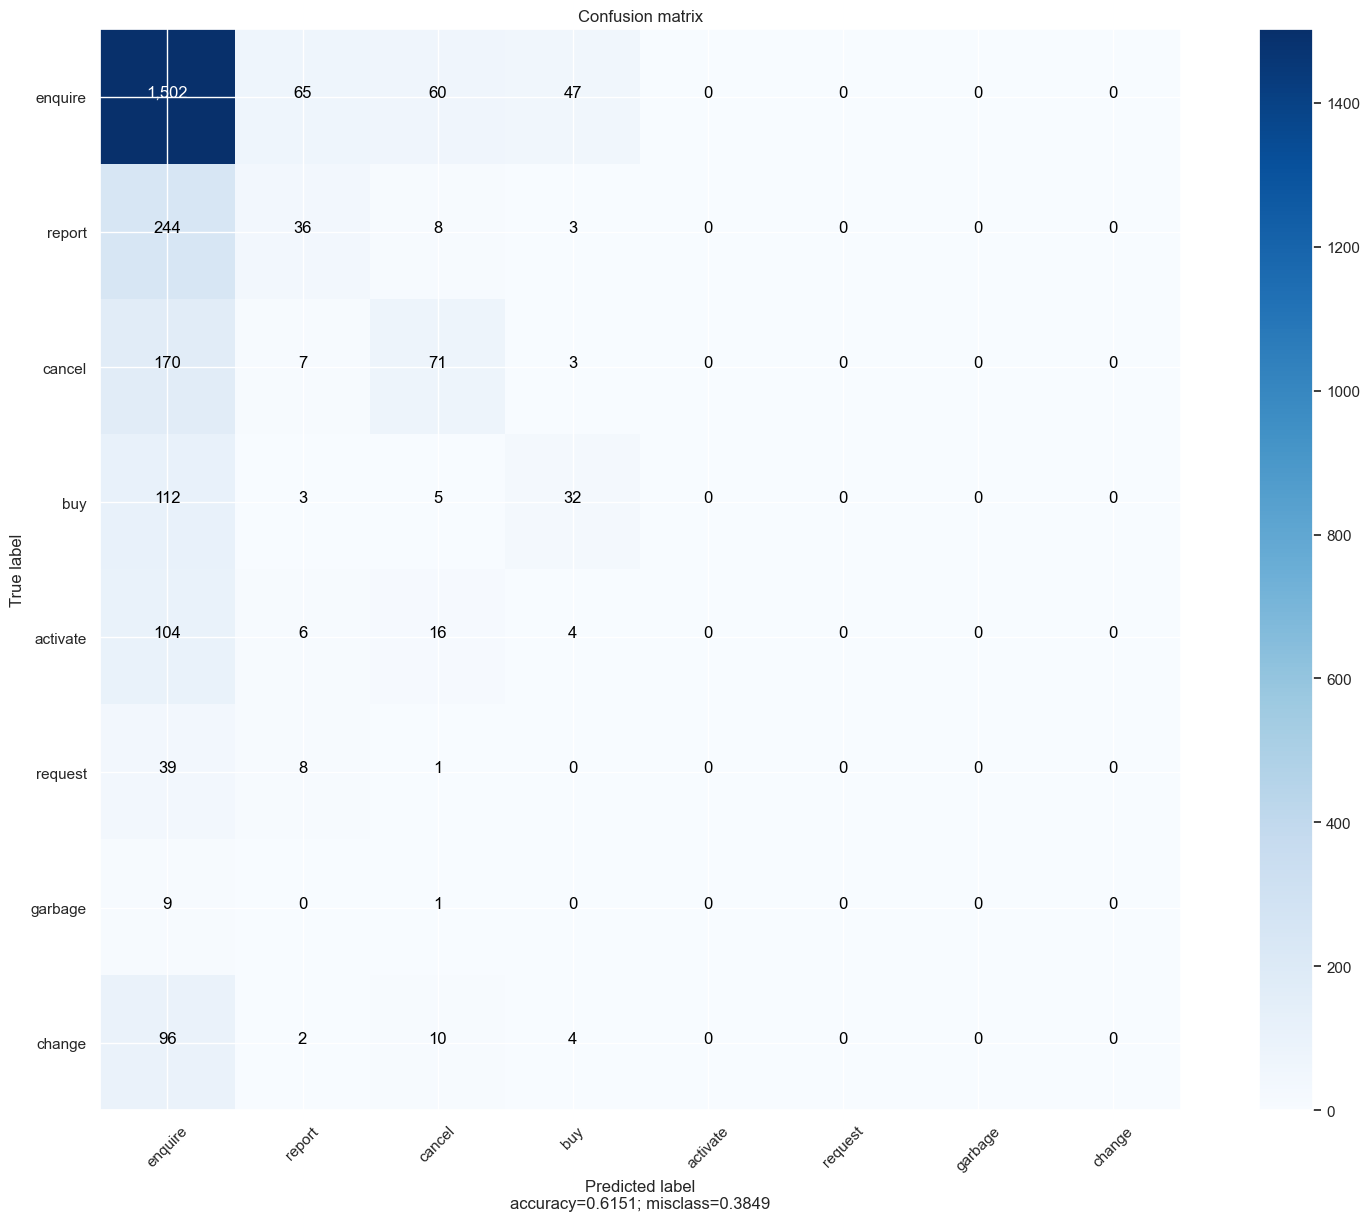

In [60]:
# Compute confusion matrix

cnf_matrix = confusion_matrix(y_true, y_pred)

# disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix,
#                                 display_labels=action_class)
# disp.plot(cmap=plt.cm.Blues, values_format='d')
plot_confusion_matrix(cnf_matrix, target_names=action_class, title='Confusion matrix', cmap=None, normalize=False)

## #TODO 4: Build and evaluate a model for "object" classification



In [61]:
#TODO 4: Build and evaluate a model for "object" classification

object_model = Text_Classification_Model(vocab_size, max_len, num_object_classes, embeddim=128)
object_model_info = build_model(object_model,
                            address = 'object_model',
                            X = object_train[0],
                            Y = object_train[1],
                            x_val = object_val[0],
                            y_val = object_val[1],
                            batch_size = 32,
                            epochs = 10)
object_model = object_model_info['model']
object_model.summary()

Model checkpoint does not exist. Building model and saving it to object_model...
Epoch 1/10
267/267 [==============================] - ETA: 0s - loss: 2.7462 - accuracy: 0.1566

INFO:tensorflow:Assets written to: object_model\assets


INFO:tensorflow:Assets written to: object_model\assets


267/267 [==============================] - 22s 78ms/step - loss: 2.7462 - accuracy: 0.1566 - val_loss: 2.6697 - val_accuracy: 0.1682
Epoch 2/10
267/267 [==============================] - ETA: 0s - loss: 2.6143 - accuracy: 0.1929

INFO:tensorflow:Assets written to: object_model\assets


INFO:tensorflow:Assets written to: object_model\assets


267/267 [==============================] - 20s 76ms/step - loss: 2.6143 - accuracy: 0.1929 - val_loss: 2.5974 - val_accuracy: 0.2043
Epoch 3/10
267/267 [==============================] - ETA: 0s - loss: 2.5161 - accuracy: 0.2183

INFO:tensorflow:Assets written to: object_model\assets


INFO:tensorflow:Assets written to: object_model\assets


267/267 [==============================] - 18s 67ms/step - loss: 2.5161 - accuracy: 0.2183 - val_loss: 2.5883 - val_accuracy: 0.2024
Epoch 4/10
267/267 [==============================] - 19s 71ms/step - loss: 2.3304 - accuracy: 0.2868 - val_loss: 2.5945 - val_accuracy: 0.2184
Epoch 5/10
267/267 [==============================] - 18s 68ms/step - loss: 2.0808 - accuracy: 0.3623 - val_loss: 2.6348 - val_accuracy: 0.2146
Epoch 6/10
267/267 [==============================] - 18s 66ms/step - loss: 1.8881 - accuracy: 0.4084 - val_loss: 2.7176 - val_accuracy: 0.2296
Epoch 7/10
267/267 [==============================] - 17s 65ms/step - loss: 1.7449 - accuracy: 0.4511 - val_loss: 2.7973 - val_accuracy: 0.2427
Epoch 8/10
267/267 [==============================] - 17s 65ms/step - loss: 1.6342 - accuracy: 0.4837 - val_loss: 2.8537 - val_accuracy: 0.2282
Epoch 8: early stopping
elapsed time:  150.1024694442749


INFO:tensorflow:Assets written to: object_model\assets


INFO:tensorflow:Assets written to: object_model\assets


Model: "Text_Classification_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 200, 128)          3041792   
                                                                 
 dropout_1 (Dropout)         (None, 200, 128)          0         
                                                                 
 conv1d_2 (Conv1D)           (None, 196, 32)           20512     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 39, 32)           0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 35, 32)            5152      
                                         

In [62]:
y_pred = object_model.predict(object_test[0])
y_unique = np.unique(object_test[1])
y_true = object_test[1]
y_pred = np.argmax(y_pred, axis=1)
print(f'True unique labels: {y_unique}')
print(f'Predicted unique labels: {np.unique(y_pred)}')
print(f'Accuracy: {np.mean(y_pred == object_test[1]) * 100:.2f}%')

84/84 [==============================] - 1s 5ms/step
True unique labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Predicted unique labels: [ 1  2  3  4  5  6  7  8  9 11 12 14 23]
Accuracy: 24.89%


In [63]:
# Classifications report
print(f'Object label: {object_reversed_label_map}')
object_class = [x for x in object_label_map.keys()]
print(f'Object class: {object_class}')

Object label: {0: 'payment', 1: 'package', 2: 'suspend', 3: 'internet', 4: 'phone_issues', 5: 'service', 6: 'nontruemove', 7: 'balance', 8: 'detail', 9: 'bill', 10: 'credit', 11: 'promotion', 12: 'mobile_setting', 13: 'iservice', 14: 'roaming', 15: 'truemoney', 16: 'information', 17: 'lost_stolen', 18: 'balance_minutes', 19: 'idd', 20: 'garbage', 21: 'ringtone', 22: 'rate', 23: 'loyalty_card', 24: 'contact', 25: 'officer'}
Object class: ['payment', 'package', 'suspend', 'internet', 'phone_issues', 'service', 'nontruemove', 'balance', 'detail', 'bill', 'credit', 'promotion', 'mobile_setting', 'iservice', 'roaming', 'truemoney', 'information', 'lost_stolen', 'balance_minutes', 'idd', 'garbage', 'ringtone', 'rate', 'loyalty_card', 'contact', 'officer']


In [64]:
print(classification_report(y_true, y_pred, target_names=object_class,zero_division=0))

                 precision    recall  f1-score   support

        payment       0.00      0.00      0.00       124
        package       0.36      0.24      0.29       353
        suspend       0.13      0.24      0.17       148
       internet       0.31      0.45      0.36       359
   phone_issues       0.19      0.09      0.12       117
        service       0.27      0.51      0.35       469
    nontruemove       0.12      0.02      0.04        41
        balance       0.17      0.26      0.21       286
         detail       0.00      0.00      0.00        64
           bill       0.12      0.13      0.12        97
         credit       0.00      0.00      0.00        32
      promotion       0.29      0.14      0.19       229
 mobile_setting       0.00      0.00      0.00        53
       iservice       0.00      0.00      0.00         5
        roaming       0.67      0.12      0.20        52
      truemoney       0.00      0.00      0.00        41
    information       0.00    

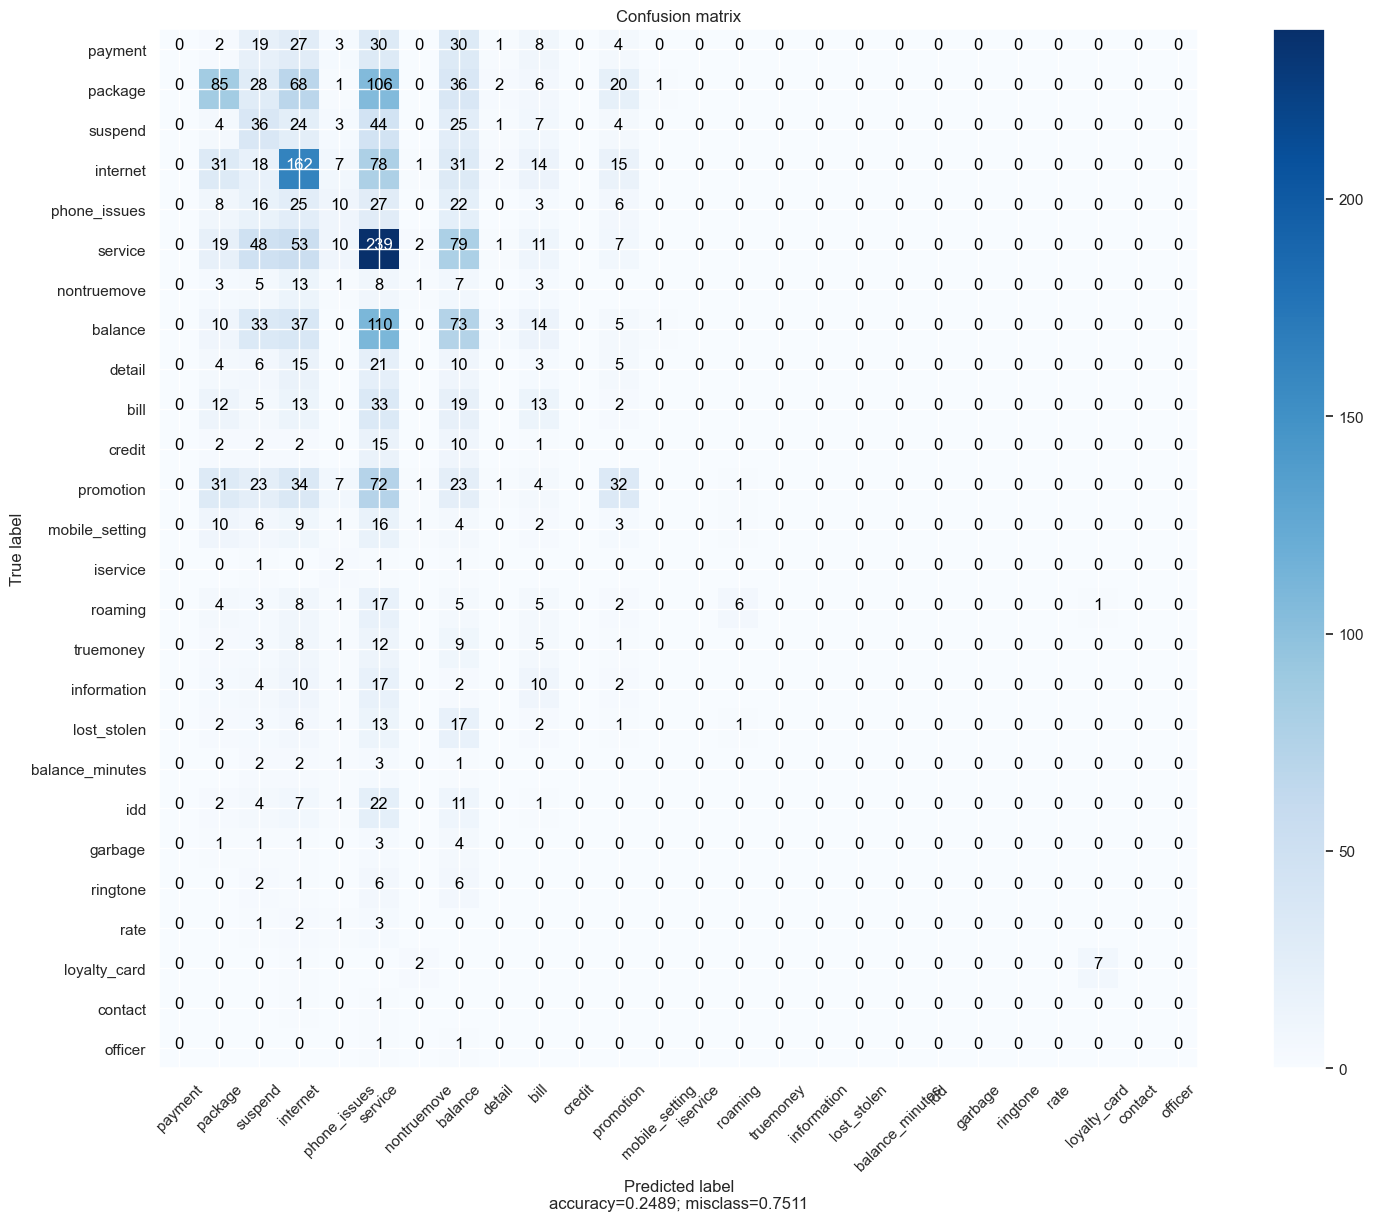

In [65]:
# Compute confusion matrix

cnf_matrix = confusion_matrix(y_true, y_pred)

plot_confusion_matrix(cnf_matrix, target_names=object_class, normalize=False)

## #TODO 5: Build and evaluate a multi-task model that does both "action" and "object" classifications in one-go 

This can be a bit tricky, if you are not familiar with the Keras functional API. PLEASE READ these webpages(https://www.tensorflow.org/guide/keras/functional, https://keras.io/getting-started/functional-api-guide/) before you start this task.   

Your model will have 2 separate output layers one for action classification task and another for object classification task. 

This is a rough sketch of what your model might look like:
image --> https://drive.google.com/file/d/1r7M6tFyQDu6pJIxLd_fn2kBMjo_CWmUK/view?usp=share_link

![Rough Sketch](pic/HW3-1_multitask_sketch.png)

In [66]:
#TODO 5: Build and evaluate a multi-task model that does both "action" and "object" classifications in one-go